### Data preparation
Prepare a subset of data from the China Health and Nutrition Survey
for analysis.
The study is described here:
https://www.cpc.unc.edu/projects/china
The data are available here (registration required):
https://www.cpc.unc.edu/projects/china/data/datasets/data-downloads-registration


In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import patsy

In [282]:
# Basic demographic data
ma = pd.read_sas("data/mast_pub_12.sas7bdat")
va = ["Idind", "GENDER", "WEST_DOB_Y"]
ma = ma.loc[:, va]

# Education data
ed = pd.read_sas("data/educ_12.sas7bdat")
va = ["IDind", "A11", "WAVE"]
ed = ed.loc[:, va]


# Income data
inc = pd.read_sas("data/indinc_10.sas7bdat")
va = ["IDind", "wave", "indwage"]
inc = inc.loc[:, va]

# Diet data
c12 = pd.read_sas("data/c12diet.sas7bdat")
va = ["IDind", "wave", "d3kcal", "d3carbo", "d3fat", "d3protn", "t1", "t2"]
c12 = c12.loc[:, va]

# Merge all time-varying data
dy = pd.merge(inc, c12, left_on=("IDind", "wave"), right_on=("IDind", "wave"))
dy = pd.merge(dy, ed, left_on=("IDind", "wave"), right_on=("IDind", "WAVE"))

# Merge time-varying with non time-varying data
df = pd.merge(dy, ma, left_on="IDind", right_on="Idind")

# Some cleanup
df = df.rename(columns={"A11": "educ", "WEST_DOB_Y": "DOB"})
df["urban"] = df.t2.replace({1: 1, 2: 0}).values
df["age"] = df["wave"] - df["DOB"]
df["female"] = df.GENDER.replace({1: 0, 2: 1}).values
df = df.dropna()

# if True:
#     # Save a copy of the data
#     df.to_csv("chns.csv.gz", index=False)


In [283]:
# drop unnecessary columns
df = df.drop('IDind', 1)
df = df.drop('WAVE', 1)
df = df.drop('GENDER', 1)
df = df.drop('t2', 1)

In [284]:
# rename the columns
df = df.rename({'wave': 'year', 'indwage': 'wage', 't1': 'province', "Idind": 'id', 'DOB': 'dob'}, axis=1) 

In [285]:
# filter to adult participants (age>18)
df = df[df.age > 18]

In [286]:
df.to_csv("chns.csv", index=False)

### Explore the dataset

In [287]:
df.describe()

,year,wage,d3kcal,d3carbo,d3fat,d3protn,province,educ,id,dob,urban,age,female
count,23781.00000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,2.378100e+04,23781.000000,23781.000000,23781.000000,23781.000000
mean,2002.41592,11860.846819,2276.305120,312.539540,78.905308,72.282496,36.649720,22.956184,3.682483e+11,1961.017283,0.458475,41.398638,0.410201
std,7.30663,21002.077214,991.275258,115.582052,88.566821,27.414062,9.928309,7.195166,9.930661e+10,12.614268,0.498283,12.402411,0.491880
min,1991.00000,3.000000,192.223833,14.015961,1.000000,4.687726,11.000000,0.000000,1.111010e+11,1912.000000,0.000000,19.000000,0.000000
25%,1997.00000,2000.000000,1790.463053,232.944832,49.855322,55.674152,32.000000,22.000000,3.211040e+11,1953.000000,0.000000,32.000000,0.000000
50%,2004.00000,6000.000000,2198.991596,303.161371,71.319433,69.115703,41.000000,23.000000,4.111010e+11,1962.000000,0.000000,41.000000,0.000000
75%,2009.00000,14400.000000,2664.650426,378.850003,97.405936,84.968612,43.000000,26.000000,4.321030e+11,1970.000000,1.000000,50.000000,1.000000
max,2011.00000,490000.000000,59537.738285,1412.390701,6501.562122,1396.149931,55.000000,36.000000,5.523040e+11,1992.000000,1.000000,92.000000,1.000000


### Urban-rural Difference in Energy Intake Patterns

#### GEE Approach

In [288]:
import statsmodels.api as sm

In [289]:
pdf = PdfPages("gee_urban_lab_plots.pdf")

In [290]:
df.describe()

,year,wage,d3kcal,d3carbo,d3fat,d3protn,province,educ,id,dob,urban,age,female
count,23781.00000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,2.378100e+04,23781.000000,23781.000000,23781.000000,23781.000000
mean,2002.41592,11860.846819,2276.305120,312.539540,78.905308,72.282496,36.649720,22.956184,3.682483e+11,1961.017283,0.458475,41.398638,0.410201
std,7.30663,21002.077214,991.275258,115.582052,88.566821,27.414062,9.928309,7.195166,9.930661e+10,12.614268,0.498283,12.402411,0.491880
min,1991.00000,3.000000,192.223833,14.015961,1.000000,4.687726,11.000000,0.000000,1.111010e+11,1912.000000,0.000000,19.000000,0.000000
25%,1997.00000,2000.000000,1790.463053,232.944832,49.855322,55.674152,32.000000,22.000000,3.211040e+11,1953.000000,0.000000,32.000000,0.000000
50%,2004.00000,6000.000000,2198.991596,303.161371,71.319433,69.115703,41.000000,23.000000,4.111010e+11,1962.000000,0.000000,41.000000,0.000000
75%,2009.00000,14400.000000,2664.650426,378.850003,97.405936,84.968612,43.000000,26.000000,4.321030e+11,1970.000000,1.000000,50.000000,1.000000
max,2011.00000,490000.000000,59537.738285,1412.390701,6501.562122,1396.149931,55.000000,36.000000,5.523040e+11,1992.000000,1.000000,92.000000,1.000000


In [324]:
# Mean structure, with and without urban effect
fml0 = "I(np.log2(d3kcal)) ~ C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5) + female + I(np.log2(wage)) + urban"
fml1 = "I(np.log2(d3kcal)) ~ C(province) + bs(year, 5) + bs(age, 5)*urban + bs(educ, 5) + female + I(np.log2(wage))"
fml2 = "I(np.log2(d3kcal)) ~ C(province) + (bs(year, 5) + bs(age, 5) + bs(educ, 5))*urban + female + I(np.log2(wage))"
fml3 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5))*urban + female + I(np.log2(wage))"
# fml4 = "I(np.log2(d3kcal)) ~ (bs(year, 5) + bs(age, 5) + bs(educ, 5))*C(province)*urban + female + I(np.log2(wage))"
fml4 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5) + female)*urban + I(np.log2(wage))"
fml5 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5))*urban * female + I(np.log2(wage))"

In [242]:
# OLS model with/without urban effects
ols_model0 = sm.OLS.from_formula(fml0, data=df)
ols_result0 = ols_model0.fit()
ols_model1 = sm.OLS.from_formula(fml1, data=df)
ols_result1 = ols_model1.fit()
ols_model2 = sm.OLS.from_formula(fml2, data=df)
ols_result2 = ols_model2.fit()
ols_model3 = sm.OLS.from_formula(fml3, data=df)
ols_result3 = ols_model3.fit()
ols_model4 = sm.OLS.from_formula(fml4, data=df)
ols_result4 = ols_model4.fit()
ols_model5 = sm.OLS.from_formula(fml5, data=df)
ols_result5 = ols_model5.fit()

In [325]:
# GEE model with/without urban effects
gee_model0 = sm.GEE.from_formula(fml0, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result0 = gee_model0.fit()
# gee_model1 = sm.GEE.from_formula(fml1, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
# gee_result1 = gee_model1.fit()
# gee_model2 = sm.GEE.from_formula(fml2, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
# gee_result2 = gee_model2.fit()
# gee_model3 = sm.GEE.from_formula(fml3, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
# gee_result3 = gee_model3.fit()
# gee_model4 = sm.GEE.from_formula(fml4, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
# gee_result4 = gee_model4.fit()
# gee_model5 = sm.GEE.from_formula(fml5, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
# gee_result5 = gee_model5.fit()


In [326]:
gee_result0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:          I(np.log2(d3kcal))   No. Observations:                23781
Model:                                 GEE   No. clusters:                    12333
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   8
Family:                           Gaussian   Mean cluster size:                 1.9
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Sun, 06 Dec 2020   Scale:                           0.173
Covariance type:                    robust   Time:                         17:06:07
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.1548      0.039    283.798      0.000      11.078      11.232
C(province)[T.21.0]     0.1697      0.024      6.997      0.000       0.122       0.217
C(province)[T.23.0]     0.1319      0.025      5.311      0.000       0.083       0.181
C(province)[T.31.0]    -0.0745      0.027     -2.729      0.006      -0.128      -0.021
C(province)[T.32.0]     0.2353      0.024      9.809      0.000       0.188       0.282
C(province)[T.37.0]     0.2232      0.024      9.138      0.000       0.175       0.271
C(province)[T.41.0]     0.1471      0.025      5.869      0.000       0.098       0.196
C(province)[T.42.0]     0.2760      0.025     11.180      0.000       0.228       0.324
C(province)[T.43.0]     0.2473      0.024     10.221      0.000       0.200       0.295
C(province)[T.45.0]     0.1888      0.024      7.705      0.000       0.141       0.237
C(province)[T.52.0]     0.2018      0.025      8.182      0.000       0.153       0.250
C(province)[T.55.0]    -0.1599      0.043     -3.693      0.000      -0.245      -0.075
bs(year, 5)[0]         -0.1040      0.015     -6.926      0.000      -0.133      -0.075
bs(year, 5)[1]         -0.1940      0.022     -8.672      0.000      -0.238      -0.150
bs(year, 5)[2]         -0.1668      0.022     -7.750      0.000      -0.209      -0.125
bs(year, 5)[3]         -0.2388      0.016    -15.032      0.000      -0.270      -0.208
bs(year, 5)[4]         -0.2981      0.012    -24.114      0.000      -0.322      -0.274
bs(age, 5)[0]           0.0942      0.031      3.015      0.003       0.033       0.155
bs(age, 5)[1]           0.0451      0.019      2.418      0.016       0.009       0.082
bs(age, 5)[2]           0.1187      0.035      3.414      0.001       0.051       0.187
bs(age, 5)[3]          -0.1223      0.060     -2.036      0.042      -0.240      -0.005
bs(age, 5)[4]          -0.5321      0.119     -4.489      0.000      -0.764      -0.300
bs(educ, 5)[0]         -0.0118      0.047     -0.253      0.800      -0.104       0.080
bs(educ, 5)[1]          0.0248      0.031      0.809      0.418      -0.035       0.085
bs(educ, 5)[2]         -0.0389      0.023     -1.725      0.085      -0.083       0.005
bs(educ, 5)[3]         -0.0627      0.037     -1.676      0.094      -0.136       0.011
bs(educ, 5)[4]         -0.0199      0.038     -0.530      0.596      -0.093       0.054
female                 -0.2636      0.006    -42.504      0.000      -0.276      -0.251
I(np.log2(wage))    -1.583e-05      0.002     -0.008      0.994      -0.004       0.004
urban                  -0.0439      0.006     -7.019      0.000      -0.056      -0.032
==============================================================================
Skew:                          0.0649   Kurtosis:                       6.0268
Centered skew:                -0.2152   Centered k

In [245]:
# Compare the two models using score tests (full urban effects, limited urban effects)
print(gee_model1.compare_score_test(gee_result0))
print(gee_model2.compare_score_test(gee_result1))
print(gee_model3.compare_score_test(gee_result2))
print(gee_model4.compare_score_test(gee_result3)) # 4 is not better than 3
print(gee_model5.compare_score_test(gee_result4))
print(gee_model5.compare_score_test(gee_result3)) # 5 is the best

{'statistic': 66.49940674068465, 'df': 6, 'p-value': 2.1305179842556754e-12}
{'statistic': 84.96253076591478, 'df': 10, 'p-value': 5.306866057708248e-14}
{'statistic': 382.79900187333686, 'df': 11, 'p-value': 0.0}
{'statistic': 1.347910871867033, 'df': 1, 'p-value': 0.2456436732747539}
{'statistic': 94.67056264490685, 'df': 52, 'p-value': 0.0002750591619586906}
{'statistic': 96.78717843091559, 'df': 53, 'p-value': 0.00022710114859392228}


In [321]:
# gee_result5.summary()
# gee_result5.cov_struct.summary()
a = gee_result8.cov_struct.dep_params
b = gee_result8.scale
icc = a / (a+b)
icc #  inter-class correlation

0.3194409809376788

In [259]:
gee_result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:          I(np.log2(d3kcal))   No. Observations:                23781
Model:                                 GEE   No. clusters:                    12333
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   8
Family:                           Gaussian   Mean cluster size:                 1.9
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Wed, 02 Dec 2020   Scale:                           0.168
Covariance type:                    robust   Time:                         10:18:44
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           11.0797      0.066    167.057      0.000      10.950      11.210
C(province)[T.21.0]                  0.2738      0.044      6.210      0.000       0.187       0.360
C(province)[T.23.0]                  0.2841      0.043      6.550      0.000       0.199       0.369
C(province)[T.31.0]                 -0.0411      0.055     -0.744      0.457      -0.149       0.067
C(province)[T.32.0]                  0.4514      0.043     10.525      0.000       0.367       0.535
C(province)[T.37.0]                  0.3112      0.043      7.212      0.000       0.227       0.396
C(province)[T.41.0]                  0.3121      0.046      6.733      0.000       0.221       0.403
C(province)[T.42.0]                  0.4450      0.045      9.968      0.000       0.357       0.532
C(province)[T.43.0]                  0.3864      0.044      8.827      0.000       0.301       0.472
C(province)[T.45.0]                  0.3579      0.043      8.259      0.000       0.273       0.443
C(province)[T.52.0]                  0.3039      0.045      6.823      0.000       0.217       0.391
C(province)[T.55.0]                 -0.0866      0.098     -0.883      0.377      -0.279       0.106
bs(year, 5)[0]                      -0.1263      0.028     -4.523      0.000      -0.181      -0.072
bs(year, 5)[1]                      -0.2719      0.039     -6.896      0.000      -0.349      -0.195
bs(year, 5)[2]                      -0.1287      0.036     -3.591      0.000      -0.199      -0.058
bs(year, 5)[3]                      -0.2036      0.025     -8.165      0.000      -0.252      -0.155
bs(year, 5)[4]                      -0.2210      0.020    -11.281      0.000      -0.259      -0.183
bs(age, 5)[0]                        0.0193      0.056      0.346      0.730      -0.090       0.129
bs(age, 5)[1]                       -0.0287      0.033     -0.870      0.384      -0.093       0.036
bs(age, 5)[2]                        0.0420      0.060      0.696      0.487      -0.076       0.160
bs(age, 5)[3]                       -0.2765      0.100     -2.765      0.006      -0.472      -0.081
bs(age, 5)[4]                       -0.7726      0.208     -3.714      0.000      -1.180      -0.365
bs(educ, 5)[0]                      -0.0669      0.083     -0.807      0.420      -0.229       0.096
bs(educ, 5)[1]                       0.0253      0.056      0.452      0.651      -0.084       0.135
bs(educ, 5)[2]                      -0.1083      0.044     -2.483      0.013      -0.194      -0.023
bs(educ, 5)[3]                      -0.0545      0.076     -0.715      0.474      -0.204       0.095
bs(educ, 5)[4]                      -0.1838      0.083     -2.206      0.027      -0.347      -0.020
urban                                0.2080      0.090      2.299      0.021      

In [247]:
out = open("gee.txt", "w")
out.write(gee_result5.summary().as_text())
# out.write("\n\n")
# out.write(result2.summary().as_text())
out.close()

In [248]:
gee_result5.qic(gee_result5.scale)

(36416.25095297997, 36382.10260799085)

In [249]:
gee_result5.qic()

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1958: UserWarning: QIC values obtained using scale=None are not appropriate for comparing models
  warnings.warn("QIC values obtained using scale=None are not "


(36416.25095297997, 36382.10260799085)

In [106]:
np.log2(df.d3kcal).describe()

count    23781.000000
mean        11.076752
std          0.462370
min          7.586643
25%         10.806117
50%         11.102626
75%         11.379731
max         15.861517
Name: d3kcal, dtype: float64

In [250]:
# Plot mean curves of log energy by age for urban and for rural,
# each with a confidence band.
def conf_band(result, province, educ, female, title):

    da = result.model.data.frame
    dx = da.iloc[0:100, :]
    province_lab = {32: "JS (South)", 37: "SD (North)", 41: "HN (North)", 52: "GD (South)"}
    educ_lab = {0: "no school", 23: "middle school degree", 26: "high school degree",
                29: "techinical degree", 33: "college degree"}
    gend_lab = {0: "male", 1: "female"}


    ti = "%s, province=%s, educ=%s, gender=%s" % (title, province_lab[province], educ_lab[educ], gend_lab[female])
#     ti = "%s, province=%d, educ=%d, gender=%d" % (title, province, educ, female)
    
    plt.clf()
    plt.axes([0.12, 0.12, 0.7, 0.8])
    plt.grid(True)

    for urban in 0, 1:
        dx.loc[:, "urban"] = urban
        dx.loc[:, "female"] = female
        dx.loc[:, "age"] = np.linspace(19, 90, 100)
        dx.loc[:, "educ"] = educ
        dx.loc[:, "wage"] = 10000
        dx.loc[:, "year"] = 2010
        dx.loc[:, "province"] = province

        # Get the estimated conditional mean values, and their
        # standard errors
        dm = patsy.dmatrix(result.model.data.design_info, dx,
                           return_type="dataframe")
        pr = np.dot(dm, result.params)
        va = np.dot(dm, np.dot(result.cov_params(), dm.T))
        se = np.sqrt(np.diag(va))

        label = "Urban" if urban == 1 else "Rural"
#         print(se)
#         print(pr)
        plt.plot(dx.age, pr, '-', label=label)

        plt.fill_between(dx.age, pr - 3*se, pr + 3*se, color='lightgrey')

    plt.title(ti, fontdict = {'fontsize' : 12})
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    plt.xlabel("Age (years)", size=12)
    plt.ylabel("Expected daily energy intaken (log scale)", size=12)
    plt.ylim(10, 12)
    pdf.savefig()


/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

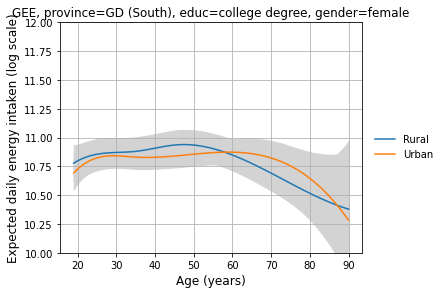

In [200]:
for province in 32, 37, 41, 52:
    for educ in 0, 23, 26, 29, 33:
        for female in 0, 1:
#             conf_band(ols_result5, province=province, educ=educ, female=female, title="OLS")
            conf_band(gee_result5, province=province, educ=educ, female=female, title="GEE")

pdf.close()

#### GEE Model Modification

In [307]:
fml5 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5))*urban * female"   
fml8 = "I(np.log2(d3kcal)) ~ C(province) *urban * female +  bs(educ, 5) + (bs(year, 5) + bs(age, 5)) * female + (bs(age, 5) + bs(year, 5))*urban"  

In [308]:
gee_model5 = sm.GEE.from_formula(fml5, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result5 = gee_model5.fit()

gee_model8 = sm.GEE.from_formula(fml8, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result8 = gee_model8.fit()


In [305]:
# fml6 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5))*urban * female  + bs(educ, 5)"       
# gee_model6 = sm.GEE.from_formula(fml6, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
# gee_result6 = gee_model6.fit()

In [306]:
# score test
print(gee_model5.compare_score_test(gee_result8)) # model 8 is better

{'statistic': 15.046662991065757, 'df': 15, 'p-value': 0.4480612303338303}


In [311]:
# qic
print(gee_result5.qic(scale=gee_result5.scale))
print(gee_result8.qic(scale=gee_result5.scale)) # model 8 is better

(36411.66842650674, 36377.62164068407)
(36341.863453503654, 36312.016421568085)


In [316]:
print(gee_result8.scale) # residual variance

0.16838146530819412


In [320]:
gee_result8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:          I(np.log2(d3kcal))   No. Observations:                23781
Model:                                 GEE   No. clusters:                    12333
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   8
Family:                           Gaussian   Mean cluster size:                 1.9
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Sun, 06 Dec 2020   Scale:                           0.168
Covariance type:                    robust   Time:                         11:57:59
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           11.0617      0.053    209.309      0.000      10.958      11.165
C(province)[T.21.0]                  0.2740      0.044      6.289      0.000       0.189       0.359
C(province)[T.23.0]                  0.2818      0.043      6.565      0.000       0.198       0.366
C(province)[T.31.0]                 -0.0349      0.055     -0.631      0.528      -0.143       0.073
C(province)[T.32.0]                  0.4535      0.042     10.701      0.000       0.370       0.537
C(province)[T.37.0]                  0.3127      0.043      7.349      0.000       0.229       0.396
C(province)[T.41.0]                  0.3143      0.046      6.900      0.000       0.225       0.404
C(province)[T.42.0]                  0.4455      0.044     10.127      0.000       0.359       0.532
C(province)[T.43.0]                  0.3868      0.043      8.961      0.000       0.302       0.471
C(province)[T.45.0]                  0.3585      0.043      8.419      0.000       0.275       0.442
C(province)[T.52.0]                  0.3071      0.044      6.985      0.000       0.221       0.393
C(province)[T.55.0]                 -0.0855      0.098     -0.874      0.382      -0.277       0.106
urban                                0.2618      0.066      3.966      0.000       0.132       0.391
C(province)[T.21.0]:urban           -0.2272      0.060     -3.778      0.000      -0.345      -0.109
C(province)[T.23.0]:urban           -0.3096      0.062     -5.006      0.000      -0.431      -0.188
C(province)[T.31.0]:urban           -0.1280      0.072     -1.785      0.074      -0.269       0.013
C(province)[T.32.0]:urban           -0.4762      0.059     -8.087      0.000      -0.592      -0.361
C(province)[T.37.0]:urban           -0.1682      0.060     -2.806      0.005      -0.286      -0.051
C(province)[T.41.0]:urban           -0.3574      0.062     -5.781      0.000      -0.479      -0.236
C(province)[T.42.0]:urban           -0.3892      0.060     -6.438      0.000      -0.508      -0.271
C(province)[T.43.0]:urban           -0.3257      0.060     -5.469      0.000      -0.442      -0.209
C(province)[T.45.0]:urban           -0.4563      0.060     -7.669      0.000      -0.573      -0.340
C(province)[T.52.0]:urban           -0.2585      0.061     -4.265      0.000      -0.377      -0.140
C(province)[T.55.0]:urban           -0.2040      0.116     -1.764      0.078      -0.431       0.023
female                              -0.4943      0.076     -6.469      0.000      -0.644      -0.345
C(province)[T.21.0]:female           0.0802      0.072      1.111      0.267      -0.061       0.222
C(province)[T.23.0]:female           0.1446      0.071      2.022      0.043       0.004       0.285
C(province)[T.31.0]:female           0.2121      0.089      2.385      0.017      

In [312]:
pdf = PdfPages("gee8_plots.pdf")

In [313]:
# Plot mean curves of log energy by age for urban and for rural,
# each with a confidence band.
def conf_band(result, province, educ, female, title):

    da = result.model.data.frame
    dx = da.iloc[0:100, :]
    province_lab = {32: "JS (South)", 37: "SD (North)", 41: "HN (North)", 52: "GD (South)"}
    educ_lab = {0: "no school", 23: "middle school degree", 26: "high school degree",
                29: "techinical degree", 33: "college degree"}
    gend_lab = {0: "male", 1: "female"}


    ti = "%s, province=%s, educ=%s, gender=%s" % (title, province_lab[province], educ_lab[educ], gend_lab[female])
#     ti = "%s, province=%d, educ=%d, gender=%d" % (title, province, educ, female)
    
    plt.clf()
    plt.axes([0.12, 0.12, 0.7, 0.8])
    plt.grid(True)

    for urban in 0, 1:
        dx.loc[:, "urban"] = urban
        dx.loc[:, "female"] = female
        dx.loc[:, "age"] = np.linspace(19, 90, 100)
        dx.loc[:, "educ"] = educ
        dx.loc[:, "year"] = 2010
        dx.loc[:, "province"] = province

        # Get the estimated conditional mean values, and their
        # standard errors
        dm = patsy.dmatrix(result.model.data.design_info, dx,
                           return_type="dataframe")
        pr = np.dot(dm, result.params)
        va = np.dot(dm, np.dot(result.cov_params(), dm.T))
        se = np.sqrt(np.diag(va))

        label = "Urban" if urban == 1 else "Rural"
#         print(se)
#         print(pr)
        plt.plot(dx.age, pr, '-', label=label)

        plt.fill_between(dx.age, pr - 3*se, pr + 3*se, color='lightgrey')

    plt.title(ti, fontdict = {'fontsize' : 12})
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    plt.xlabel("Age (years)", size=12)
    plt.ylabel("Expected daily energy intaken (log scale)", size=12)
    plt.ylim(10, 12)
    pdf.savefig()


/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

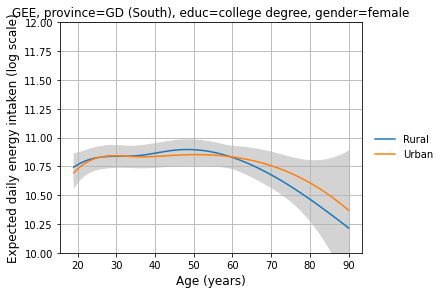

In [314]:
for province in 32, 37, 41, 52:
    for educ in 0, 23, 26, 29, 33:
        for female in 0, 1:
#             conf_band(ols_result5, province=province, educ=educ, female=female, title="OLS")
            conf_band(gee_result8, province=province, educ=educ, female=female, title="GEE")

pdf.close()

In [315]:
gee_result8.summary()
out = open("gee_result8.txt", "w")
out.write(gee_result8.summary().as_text())
# out.write("\n\n")
# out.write(result2.summary().as_text())
out.close()

#### Linear Mixed Effect Approach

In [76]:
df["age_cen"] = df.age - df.age.mean()
df["age_imean"] = df.groupby("id")["age"].transform(np.mean)
df["age_icen"] = df["age"] - df["age_imean"]


In [318]:
# Mean structure, with and without sex differences
fml8 = "I(np.log2(d3kcal)) ~ C(province) *urban * female +  bs(educ, 5) + (bs(year, 5) + bs(age, 5)) * female + (bs(age, 5) + bs(year, 5))*urban"  

In [319]:
# Random intercepts for subjects
model1 = sm.MixedLM.from_formula(fml8, re_formula="1", groups="id", data=df)
result1 = model1.fit()

In [79]:
result1.summary()
# print(result1)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                MixedLM     Dependent Variable:     I(np.log2(d3kcal))
No. Observations:     23781       Method:                 REML              
No. Groups:           12333       Scale:                  0.1516            
Min. group size:      1           Log-Likelihood:         -12703.8693       
Max. group size:      8           Converged:              Yes               
Mean group size:      1.9                                                   
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                        11.081    0.064 172.819 0.000 10.956 11.207
C(province)[T.21.0]               0.274    0.041   6.612 0.000  0.193  0.355
C(province)[T.23.0]               0.284    0.043   6.618 0.000  0.200  0.369
C(province)[T.31.0]              -0.041    0.049  -0.835 0.404 -0.137  0.055
C(province)[T.32.0]               0.451    0.041  11.090 0.000  0.371  0.530
C(province)[T.37.0]               0.311    0.041   7.649 0.000  0.231  0.391
C(province)[T.41.0]               0.312    0.042   7.371 0.000  0.229  0.395
C(province)[T.42.0]               0.446    0.042  10.657 0.000  0.364  0.528
C(province)[T.43.0]               0.386    0.042   9.295 0.000  0.305  0.468
C(province)[T.45.0]               0.358    0.041   8.792 0.000  0.278  0.438
C(province)[T.52.0]               0.304    0.042   7.212 0.000  0.221  0.386
C(province)[T.55.0]              -0.086    0.060  -1.432 0.152 -0.204  0.032
bs(year, 5)[0]                   -0.126    0.031  -4.043 0.000 -0.188 -0.065
bs(year, 5)[1]                   -0.273    0.039  -7.018 0.000 -0.349 -0.196
bs(year, 5)[2]                   -0.131    0.037  -3.525 0.000 -0.203 -0.058
bs(year, 5)[3]                   -0.204    0.026  -7.793 0.000 -0.256 -0.153
bs(year, 5)[4]                   -0.222    0.020 -11.262 0.000 -0.261 -0.184
bs(age, 5)[0]                     0.018    0.055   0.331 0.741 -0.089  0.125
bs(age, 5)[1]                    -0.030    0.032  -0.909 0.363 -0.093  0.034
bs(age, 5)[2]                     0.040    0.057   0.708 0.479 -0.071  0.152
bs(age, 5)[3]                    -0.277    0.093  -2.972 0.003 -0.460 -0.094
bs(age, 5)[4]                    -0.773    0.192  -4.026 0.000 -1.149 -0.397
bs(educ, 5)[0]                   -0.070    0.081  -0.866 0.387 -0.228  0.088
bs(educ, 5)[1]                    0.027    0.055   0.480 0.631 -0.082  0.135
bs(educ, 5)[2]                   -0.109    0.043  -2.554 0.011 -0.193 -0.025
bs(educ, 5)[3]                   -0.046    0.075  -0.617 0.537 -0.193  0.101
bs(educ, 5)[4]                   -0.190    0.081  -2.357 0.018 -0.348 -0.032
urban                             0.207    0.091   2.268 0.023  0.028  0.385
C(province)[T.21.0]:urban        -0.227    0.056  -4.062 0.000 -0.337 -0.118
C(province)[T.23.0]:urban        -0.307    0.058  -5.305 0.000 -0.420 -0.193
C(province)[T.31.0]:urban        -0.117    0.064  -1.827 0.068 -0.243  0.009
C(province)[T.32.0]:urban        -0.473    0.055  -8.645 0.000 -0.580 -0.365
C(province)[T.37.0]:urban        -0.164    0.056  -2.945 0.003 -0.274 -0.055
C(province)[T.41.0]:urban        -0.355    0.056  -6.309 0.000 -0.465 -0.244
C(province)[T.42.0]:urban        -0.388    0.056  -6.917 0.000 -0.498 -0.278
C(province)[T.43.0]:urban        -0.326    0.056  -5.835 0.000 -0.435 -0.216
C(province)[T.45.0]:urban        -0.453    0.057  -7.973 0.000 -0.565 -0.342
C(province)[T.52.0]:urban        -0.251    0.057  -4.401 0.000 -0.363 -0.139
C(province)[T.55.0]:urban        -0.195    0.079  -2.476 0.013 -0.350 -0.041
bs(year, 5)[0]:urban              0.018    0.046   0.397 0.691 -0.072  0.108
bs(year, 5)[1]:urban              0.166    0

In [80]:
# Random intercepts for subjects, and random slopes for age within subjects
vcf = {"age": "0 + age_icen:C(id)"}
model2 = sm.MixedLM.from_formula(fml5, re_formula="", vc_formula=vcf, groups="id", data=df)
result2 = model2.fit()


/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [81]:
result2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                MixedLM     Dependent Variable:     I(np.log2(d3kcal))
No. Observations:     23781       Method:                 REML              
No. Groups:           12333       Scale:                  0.1497            
Min. group size:      1           Log-Likelihood:         -12701.2831       
Max. group size:      8           Converged:              Yes               
Mean group size:      1.9                                                   
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                        11.081    0.064 172.761 0.000 10.955 11.206
C(province)[T.21.0]               0.274    0.041   6.634 0.000  0.193  0.355
C(province)[T.23.0]               0.285    0.043   6.637 0.000  0.201  0.369
C(province)[T.31.0]              -0.041    0.049  -0.836 0.403 -0.137  0.055
C(province)[T.32.0]               0.451    0.041  11.117 0.000  0.371  0.530
C(province)[T.37.0]               0.312    0.041   7.673 0.000  0.232  0.391
C(province)[T.41.0]               0.312    0.042   7.394 0.000  0.230  0.395
C(province)[T.42.0]               0.446    0.042  10.691 0.000  0.365  0.528
C(province)[T.43.0]               0.387    0.041   9.322 0.000  0.305  0.468
C(province)[T.45.0]               0.358    0.041   8.820 0.000  0.279  0.438
C(province)[T.52.0]               0.304    0.042   7.235 0.000  0.222  0.387
C(province)[T.55.0]              -0.086    0.060  -1.432 0.152 -0.204  0.032
bs(year, 5)[0]                   -0.127    0.031  -4.068 0.000 -0.188 -0.066
bs(year, 5)[1]                   -0.272    0.039  -7.004 0.000 -0.348 -0.196
bs(year, 5)[2]                   -0.131    0.037  -3.537 0.000 -0.203 -0.058
bs(year, 5)[3]                   -0.204    0.026  -7.746 0.000 -0.255 -0.152
bs(year, 5)[4]                   -0.222    0.020 -11.197 0.000 -0.261 -0.183
bs(age, 5)[0]                     0.017    0.055   0.319 0.750 -0.090  0.125
bs(age, 5)[1]                    -0.032    0.033  -0.973 0.330 -0.096  0.032
bs(age, 5)[2]                     0.043    0.057   0.749 0.454 -0.069  0.155
bs(age, 5)[3]                    -0.282    0.094  -3.006 0.003 -0.466 -0.098
bs(age, 5)[4]                    -0.773    0.192  -4.021 0.000 -1.150 -0.396
bs(educ, 5)[0]                   -0.072    0.081  -0.891 0.373 -0.230  0.086
bs(educ, 5)[1]                    0.028    0.055   0.512 0.608 -0.080  0.137
bs(educ, 5)[2]                   -0.110    0.043  -2.568 0.010 -0.194 -0.026
bs(educ, 5)[3]                   -0.044    0.075  -0.588 0.557 -0.191  0.103
bs(educ, 5)[4]                   -0.191    0.081  -2.362 0.018 -0.349 -0.032
urban                             0.206    0.091   2.261 0.024  0.027  0.385
C(province)[T.21.0]:urban        -0.227    0.056  -4.063 0.000 -0.336 -0.117
C(province)[T.23.0]:urban        -0.306    0.058  -5.304 0.000 -0.420 -0.193
C(province)[T.31.0]:urban        -0.117    0.064  -1.831 0.067 -0.243  0.008
C(province)[T.32.0]:urban        -0.472    0.055  -8.651 0.000 -0.579 -0.365
C(province)[T.37.0]:urban        -0.164    0.056  -2.946 0.003 -0.274 -0.055
C(province)[T.41.0]:urban        -0.354    0.056  -6.312 0.000 -0.464 -0.244
C(province)[T.42.0]:urban        -0.388    0.056  -6.924 0.000 -0.498 -0.278
C(province)[T.43.0]:urban        -0.326    0.056  -5.838 0.000 -0.435 -0.216
C(province)[T.45.0]:urban        -0.453    0.057  -7.983 0.000 -0.564 -0.342
C(province)[T.52.0]:urban        -0.251    0.057  -4.398 0.000 -0.362 -0.139
C(province)[T.55.0]:urban        -0.195    0.079  -2.482 0.013 -0.349 -0.041
bs(year, 5)[0]:urban              0.019    0.046   0.413 0.680 -0.071  0.109
bs(year, 5)[1]:urban              0.165    0

In [202]:
out = open("lme.txt", "w")
out.write(result1.summary().as_text())
out.write("\n\n")
out.write(result2.summary().as_text())
out.close()